In [1]:
from sklearn.metrics import f1_score, confusion_matrix, make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from fairlearn.metrics import (
    count,
    selection_rate,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
    demographic_parity_difference
)

from fairlearn.datasets import fetch_adult
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

import numpy as np
import optuna
import tqdm as notebook_tqdm

import dill
import optuna
import plotly

/home/azucena/miniconda3/envs/fairenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## One simulation

In [2]:
data = fetch_adult(as_frame=True)a
X_raw = data.data
y = (data.target == ">50K") * 1
A = X_raw["sex"]

(X_train, X_test, y_train, y_test, A_train, A_test) = train_test_split(
    X_raw, y, A, test_size=0.8, random_state=12345, stratify=y
)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
A_train = A_train.reset_index(drop=True)
A_test = A_test.reset_index(drop=True)

numeric_transformer = Pipeline(
    steps=[
        ("impute", SimpleImputer()),
        ("scaler", StandardScaler()),
    ]
)
categorical_transformer = Pipeline(
    [
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ]
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            LGBMClassifier(n_jobs=-1),
        ),
    ]
)

/home/azucena/miniconda3/envs/fairenv/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Hyperparameter Optimization

In [3]:

file_name = 'f1-dpd-lgbm-motpe-succesivehalving-100trials.pkl'
with open(file_name, 'rb') as in_strm:
    results = dill.load(in_strm)

In [4]:

optuna.visualization.plot_pareto_front(results, target_names=["fair_metric", "f1_score"], include_dominated_trials = False)

In [5]:
optuna.visualization.plot_pareto_front(results, target_names=["fair_metric", "f1_score"], include_dominated_trials = True)

In [7]:
#results_df.head(2)

/tmp/ipykernel_82947/232719886.py:1: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



<Axes: title={'center': 'Hyperparameter Importances'}, xlabel="Importance for ['Fair metric']", ylabel='Hyperparameter'>

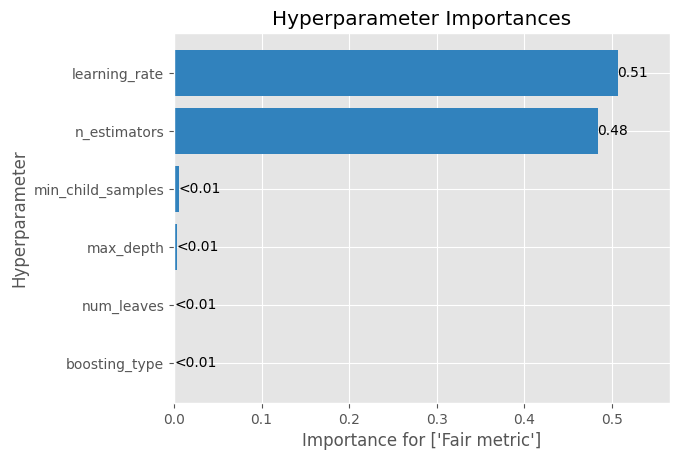

In [8]:
optuna.visualization.matplotlib.plot_param_importances(results, target = lambda t: t.values[0], target_name = ["Fair metric"])

/tmp/ipykernel_82947/3662930217.py:1: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



<Axes: title={'center': 'Hyperparameter Importances'}, xlabel="Importance for ['Model metric']", ylabel='Hyperparameter'>

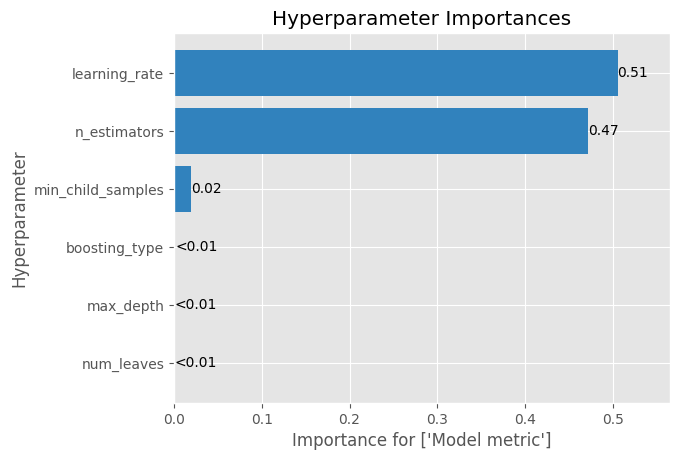

In [9]:
optuna.visualization.matplotlib.plot_param_importances(results, target = lambda t: t.values[1], target_name = ["Model metric"])

In [12]:
import matplotlib.pyplot as plt
results_df = results.trials_dataframe()

#results_df['value'].sort_values().reset_index(drop=True).plot()
#plt.title('Convergence plot')
#plt.xlabel('Iteration')
#plt.ylabel('Accuracy')

In [24]:
results.best_trials[1].values

[0.16980866191463653, 0.702903178160778]

In [25]:
fair_metric = []
model_metric = []
for i in range(len(results.best_trials)):
    best_params = {key.replace('lgbm_',''):value for key, value in results.best_trials[i].params.items()}
    pipeline['classifier'].set_params(**best_params)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)  
    fair_metric.append(np.abs(demographic_parity_difference(y_test, y_pred, sensitive_features=A_test)))
    model_metric.append(f1_score(y_test, y_pred))
    #fair_metric
    #print(best_params)
    #print(results.best_trials[i].values)

In [26]:
fair_metric_train = [results.best_trials[i].values[0] for i in range(len(results.best_trials))]
model_metric_train = [results.best_trials[i].values[1] for i in range(len(results.best_trials))]

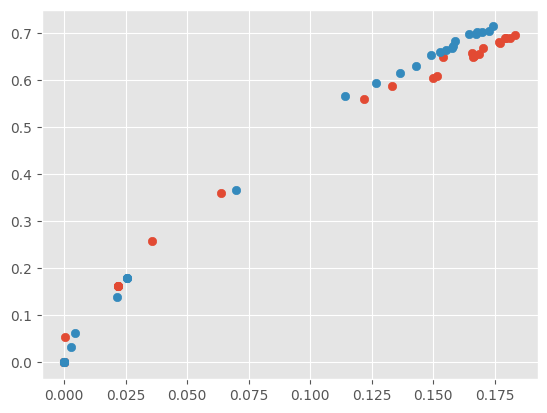

In [27]:
plt.scatter(fair_metric, model_metric)
plt.scatter(fair_metric_train, model_metric_train)

In [52]:
fairness_metrics = list(zip(fair_metric_train, fair_metric))
fairness_metrics_ = sorted(fairness_metrics, key = lambda x: x[0])
#fairness_metrics_

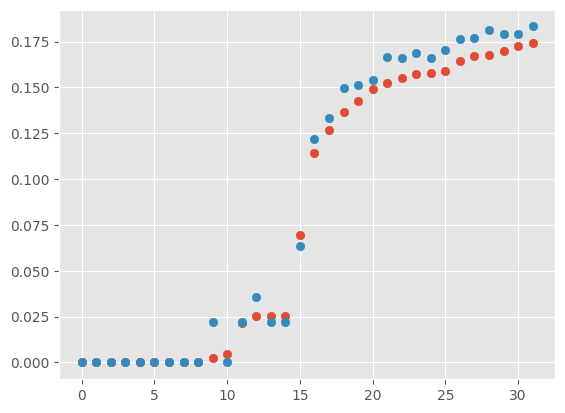

In [61]:
plt.scatter(range(len(fair_metric_train)),list(zip(*fairness_metrics_))[0])
plt.scatter(range(len(fair_metric_train)), list(zip(*fairness_metrics_))[1])

In [62]:
model_metrics = list(zip(model_metric_train, model_metric))
model_metrics_ = sorted(model_metrics, key = lambda x: x[0])

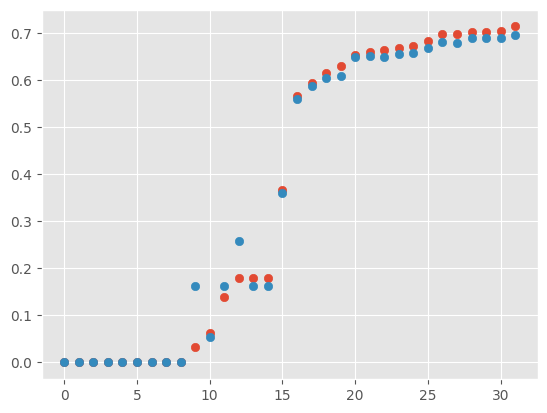

In [63]:
plt.scatter(range(len(fair_metric_train)),list(zip(*model_metrics_))[0])
plt.scatter(range(len(fair_metric_train)), list(zip(*model_metrics_))[1])

In [28]:
n = 1
best_params = {key.replace('lgbm_',''):value for key, value in results.best_trials[n].params.items()}
pipeline['classifier'].set_params(**best_params)

LGBMClassifier(learning_rate=0.46799607752301065, max_depth=2,
               min_child_samples=65, n_estimators=2261, num_leaves=359)

In [29]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [30]:
fair_value = np.abs(equalized_odds_difference(y_test, y_pred, sensitive_features=A_test))
model_value = f1_score(y_test, y_pred) 
print(fair_value)
print(model_value)

0.08491853498663993
0.6986259541984733


## Several Simulations

In [2]:
file_name = 'f1-dpd-lgbm-motpe-succesivehalving-100trials-4sim.pkl'
with open(file_name, 'rb') as in_strm:
    results = dill.load(in_strm)

In [19]:
data = fetch_adult(as_frame=True)
X_raw = data.data
y = (data.target == ">50K") * 1
A = X_raw["sex"]

(X_train, X_test, y_train, y_test, A_train, A_test) = train_test_split(
    X_raw, y, A, test_size=0.8, random_state=12345, stratify=y
)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
A_train = A_train.reset_index(drop=True)
A_test = A_test.reset_index(drop=True)

numeric_transformer = Pipeline(
    steps=[
        ("impute", SimpleImputer()),
        ("scaler", StandardScaler()),
    ]
)
categorical_transformer = Pipeline(
    [
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ]
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            LGBMClassifier(n_jobs=-1),
        ),
    ]
)

/home/azucena/miniconda3/envs/fairenv/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [21]:
fair_sim_u = []
model_sim_u = []
fair_sim = []
model_sim = []
res_fair_sim = []
res_model_sim = []
for sim_n,res in enumerate(results):
    print(sim_n)
    (X_train, X_test, y_train, y_test, A_train, A_test) = train_test_split(
    X_raw, y, A, test_size=0.8, stratify=y, random_state=sim_n
    )

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    A_train = A_train.reset_index(drop=True)
    A_test = A_test.reset_index(drop=True)

    pipeline.steps.pop(1)
    pipeline.steps.insert(1,('classifier',LGBMClassifier(n_jobs=-1)))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    fair_sim_u.append((np.abs(demographic_parity_difference(y_test, y_pred, sensitive_features=A_test))))
    model_sim_u.append(f1_score(y_test, y_pred))

    fair_value = []
    model_value = []
    res_fair_value = []
    res_model_value = []
    for i in range(len(res.best_trials)):
        best_params = {key.replace('lgbm_',''):value for key, value in res.best_trials[i].params.items()}
        pipeline['classifier'].set_params(**best_params)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)  
        res_fair_value.append(res.best_trials[i].values[0])
        res_model_value.append(res.best_trials[i].values[1])
        fair_value.append(np.abs(demographic_parity_difference(y_test, y_pred, sensitive_features=A_test)))
        model_value.append(f1_score(y_test, y_pred))

    res_fair_sim.append(res_fair_value)
    res_model_sim.append(res_model_value)
    fair_sim.append(fair_value)
    model_sim.append(model_value)


In [ ]:
fairness_metrics = list(zip(fair_metric_train, fair_metric))
fairness_metrics_ = sorted(fairness_metrics, key = lambda x: x[0])

In [ ]:
fair_metric_train = [results.best_trials[i].values[0] for i in range(len(res.best_trials)) for res in results]
model_metric_train = [results.best_trials[i].values[1] for i in range(len(res.best_trials)) for res in results]

In [ ]:
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i,ax in zip(range(len(fair_sim)),axes.ravel()):
    order = results[i].F[:,0].argsort()
    ax.scatter(range(len(fair_sim[i])), results[i].F[order,0])
    #ax.scatter(fair_sim[i], model_sim[i])
    #ax.scatter(fair_sim_u[i], model_sim_u[i])